In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [2]:
import nltk
import torch.nn.functional as F
import spacy
from tqdm.notebook import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from collections import Counter
from nltk.tokenize import word_tokenize

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:616: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
df = pd.read_csv("./reviews.csv")
sia = SentimentIntensityAnalyzer()

In [4]:
df['content'].values[0]

'smooth Good And better Quality'

In [5]:
test = df['content'][0]
print (test)
tokens = nltk.word_tokenize(test)
nltk.pos_tag(tokens)
sia.polarity_scores(test)

smooth Good And better Quality


{'neg': 0.0, 'neu': 0.341, 'pos': 0.659, 'compound': 0.7003}

In [6]:
pipe = pipeline("text-classification", model="finiteautomata/bertweet-base-sentiment-analysis")

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [7]:
pipe(test)

[{'label': 'POS', 'score': 0.9776937961578369}]

In [8]:
# Function to analyze sentiment using NLTK's SentimentIntensityAnalyzer
def analyze_sentiment_nltk(text):
    scores = sia.polarity_scores(text)
    return scores

In [9]:
# Function to analyze sentiment using Hugging Face pipeline
def analyze_sentiment_transformer(text):
    test = text[:200]
    result = pipe(test)[0]
    return result

In [10]:
# Apply sentiment analysis to all reviews
nltk_sentiments = df['content'].apply(analyze_sentiment_nltk)
transformer_sentiments = df['content'].apply(analyze_sentiment_transformer)

In [11]:
# Convert the results to separate DataFrames
nltk_df = pd.DataFrame(nltk_sentiments.tolist())
transformer_df = pd.DataFrame(transformer_sentiments.tolist())

In [12]:
# Combine the results with the original DataFrame
df = pd.concat([df, nltk_df, transformer_df], axis=1)
# Save the DataFrame to a new CSV file
df.to_csv('updated_reviews.csv', index=False)

In [13]:
# Display the DataFrame with sentiment scores
print(df.head())


   rating                                            content  \
0     NaN                     smooth Good And better Quality   
1     NaN  Only thing bad is camera quality. Worst image ...   
2     NaN  It’s a great product for the price . Very flui...   
3     NaN                                      Super quality   
4     NaN  Redmi 12 5G (6GB/128GB)\n\nOverview: Having us...   

                                             variant               name  \
0  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...  Salik Ahamad Khan   
1  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...          Darshan P   
2  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...       Yajveer Arya   
3  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...           Srinivas   
4  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...        Placeholder   

                               date  verified sub_reviews    neg    neu  \
0   Reviewed in India on 8 May 2024      True          []  0.000  0.341   
1  Reviewed in

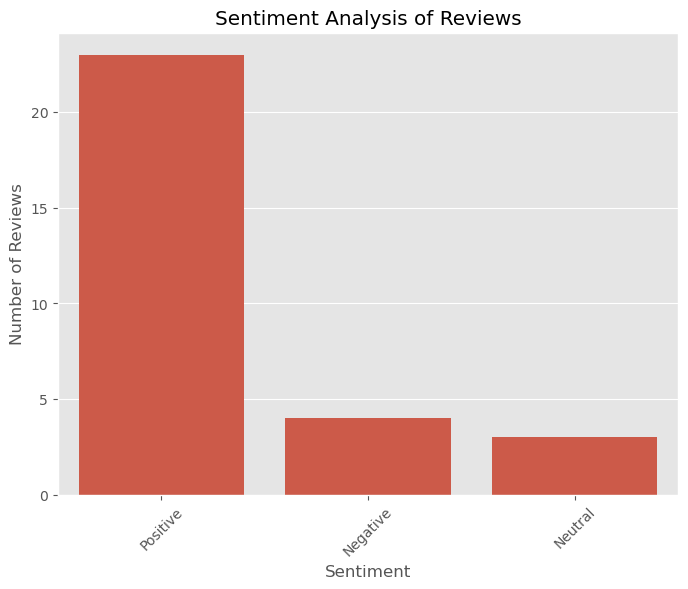

In [14]:
# Count the number of positive, negative, and neutral reviews
positive_count = df['compound'].apply(lambda x: 1 if x >= 0.05 else 0).sum()
negative_count = df['compound'].apply(lambda x: 1 if x <= -0.05 else 0).sum()
neutral_count = df['compound'].apply(lambda x: 1 if -0.05 < x < 0.05 else 0).sum()

# Create a data frame for plotting
plot_data = pd.DataFrame({'Sentiment': ['Positive', 'Negative', 'Neutral'],
                           'Count': [positive_count, negative_count, neutral_count]})

# Plot the bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Sentiment', y='Count', data=plot_data)
plt.title('Sentiment Analysis of Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [15]:
### this is the second part

In [16]:
negative_reviews = df[df['label'] == 'NEG']['content']

# Create a dictionary to store the aspect terms and their counts
aspect_counts = {}

# Load spaCy model for tokenization and lemmatization
nlp = spacy.load("en_core_web_md")

# Function to extract aspects from negative sentiment
def extract_aspects(text):
    doc = nlp(text)
    aspects = []
    for token in doc:
        if token.pos_ == "NOUN" and not token.is_stop:
            aspect = token.lemma_
            aspects.append(aspect)
    return aspects

# Iterate over negative reviews and extract aspects
for review in negative_reviews:
    aspects = extract_aspects(review)
    for aspect in aspects:
        if aspect in aspect_counts:
            aspect_counts[aspect] += 1
        else:
            aspect_counts[aspect] = 1

# Print the most common aspects in negative reviews
common_aspects = sorted(aspect_counts.items(), key=lambda x: x[1], reverse=True)
print("Most common aspects in negative reviews:")
for aspect, count in common_aspects:
    print(f"{aspect}: {count}")

Most common aspects in negative reviews:
phone: 6
battery: 6
camera: 4
quality: 4
thing: 2
image: 2
video: 2
1hr: 2
processing: 1
device: 1
speed: 1
heat: 1
cam: 1
file: 1
jpeg: 1
resolution: 1
size: 1
pixel: 1
dont: 1
bother: 1
shot: 1
picture: 1
motion: 1
capture: 1
feature: 1
fingerprint: 1
senser: 1
connectivity: 1
delivery: 1
agent: 1
extra: 1
issue: 1
detail: 1
invoice: 1
information: 1
alot: 1
aur: 1
movie: 1
bcz: 1


In [17]:
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1",use_fast=False)
absa_model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

In [20]:
# Function to perform ABSA on a given sentence and aspect
def analyze_aspect_sentiment(sentence, aspect):
    inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
    outputs = absa_model(**inputs)
    probs = F.softmax(outputs.logits, dim=1).detach().numpy()[0]
    sentiments = {label: prob for label, prob in zip(["negative", "neutral", "positive"], probs)}
    return sentiments


In [21]:
# Create a list to store the ABSA results
absa_results = []

# Iterate over negative reviews and perform ABSA
for review in tqdm(negative_reviews, desc="Analyzing aspects"):
    doc = nlp(review)
    for chunk in doc.noun_chunks:
        aspect = chunk.text
        sentiments = analyze_aspect_sentiment(review, aspect)
        absa_results.append({
            'review': review,
            'aspect': aspect,
            'negative': sentiments['negative'],
            'neutral': sentiments['neutral'],
            'positive': sentiments['positive']
        })

# Convert ABSA results to a DataFrame and save to a new CSV file
absa_df = pd.DataFrame(absa_results)
absa_df.to_csv('aspect_sentiment_analysis.csv', index=False)

print("Aspect sentiment analysis completed and saved to 'aspect_sentiment_analysis.csv'")

Analyzing aspects:   0%|          | 0/5 [00:00<?, ?it/s]

Aspect sentiment analysis completed and saved to 'aspect_sentiment_analysis.csv'
